Preparations before you start:
- Activate all the APIs for Product Search, AutoML, AI Notebooks
- Create AI Notebooks instance and clone workshop code from https://github.com/marsbroshok/retailsearch

Steps in this notebook:
- Download a Kaggle image dataset (https://www.kaggle.com/paramaggarwal/fashion-product-images-dataset-small)
- Filter to watch only images
- Prepare a bulk import format csv
- Prepare a AutoML classifiaction csv

Use "VisionProductSearch" notebook to index and query products

(Optional) [Custom ML with AI Platform](https://pantheon.corp.google.com/ai/platform/datasets?project=google.com:ml-baguette-demos): Import images and train an AutoML Image Classification model to describe product image automatically

Things to try:
- Use other product category or all products with no filter
- Change data by your own dataset and compare with your curretn baseline


In [1]:
# Setups
!pip install --user kaggle

In [2]:
# Imports
import pandas as pd
import tensorflow as tf
from tensorflow.io.gfile import GFile
from matplotlib import pyplot as plt

In [3]:
# Common variables
BUCKET_NAME = "auv-product-search-workshop"
REGION = 'europe-west4'

In [118]:
# Create GCS bucket
!gsutil mb -c STANDARD -l {REGION} gs://{BUCKET_NAME}

Creating gs://auv-product-search-workshop/...


In [7]:
# Download dataset
!~/.local/bin/kaggle datasets download -d paramaggarwal/fashion-product-images-small

 96%|██████████████████████████████████████▌ | 545M/565M [00:11<00:00, 46.3MB/s]
100%|████████████████████████████████████████| 565M/565M [00:11<00:00, 51.1MB/s]


In [22]:
# Unzip
!unzip -q fashion-product-images-small.zip -d ../../fashion-product-images-small
!rm -r ~/fashion-product-images-small/myntradataset

In [31]:
!ls ~/fashion-product-images-small/

images	styles.csv


In [119]:
# Copy to GCS
!gsutil -mq cp -r ~/fashion-product-images-small gs://{BUCKET_NAME}/
!gsutil -mq cp test_gan_watch.jpg gs://{BUCKET_NAME}/

In [120]:
# Let's read the dataset labels
with GFile(f"gs://{BUCKET_NAME}/fashion-product-images-small/styles.csv") as f:
    df = pd.read_csv(f, error_bad_lines=False)

df.head()

b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields, saw 11\nSkipping line 33020: expected 10 fields, saw 11\nSkipping line 35748: expected 10 fields, saw 11\nSkipping line 35962: expected 10 fields, saw 11\nSkipping line 37770: expected 10 fields, saw 11\nSkipping line 38105: expected 10 fields, saw 11\nSkipping line 38275: ex

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [121]:
df_watches = df[df.subCategory=='Watches']

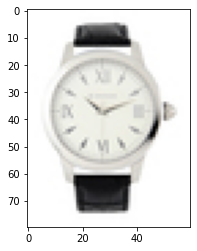

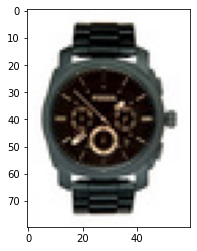

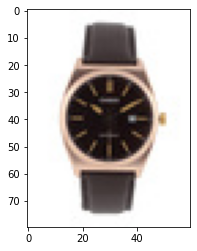

In [122]:
plt.close('all')

for _ in range(3):
    sample = df_watches.sample(n=1).id.values[0]
    fn = f"gs://{BUCKET_NAME}/fashion-product-images-small/images/{sample}.jpg"

    with GFile(fn, 'rb') as f:
        img = plt.imread(f)

    fig = plt.figure()
    plt.imshow(img)
    fig.show()

In [123]:
# Prepare a bulk csv
# Check the expected format
!gsutil cat gs://cloud-samples-data/vision/product_search/product_catalog.csv | head

gs://cloud-ai-vision-data/product-search-tutorial/images/46a0cbcf70ba11e89399d20059124800.jpg,image0,product_set0,product_id0,apparel-v2,,"style=women,category=shoe",
gs://cloud-ai-vision-data/product-search-tutorial/images/46a1aea370ba11e888d4d20059124800.jpg,image1,product_set0,product_id1,apparel-v2,,"style=men,category=shoe",
gs://cloud-ai-vision-data/product-search-tutorial/images/46a1cdb370ba11e8b538d20059124800.jpg,image2,product_set0,product_id2,apparel-v2,,"style=women,category=dress",
gs://cloud-ai-vision-data/product-search-tutorial/images/46a01f0770ba11e88598d20059124800.jpg,image3,product_set0,product_id3,apparel-v2,,"style=men,category=shoe",
gs://cloud-ai-vision-data/product-search-tutorial/images/46a03b2670ba11e8b18ad20059124800.jpg,image4,product_set0,product_id4,apparel-v2,,"style=women,category=dress",
gs://cloud-ai-vision-data/product-search-tutorial/images/46a0016b70ba11e896d8d20059124800.jpg,image5,product_set0,product_id5,apparel-v2,,"style=women,category=dress",

In [124]:
df['gcs_path'] = df.id.apply(lambda v: f"gs://{BUCKET_NAME}/fashion-product-images-small/images/{v}.jpg")

In [125]:
df['image_id'] = df.id.apply(lambda v: f"image_{v}")

In [126]:
df['product_set'] = df.subCategory.apply(lambda v: "product_watches_0" if v=="Watches" else "product_general_0")

In [127]:
df['product_id'] = df.index.map(lambda v: f"product_id_{v}")

In [128]:
df['category'] = "apparel-v2"

In [129]:
df['display_name'] = df.productDisplayName

In [130]:
df['keywords'] = df.apply(
    lambda v: f"articleType={v['articleType']},baseColour={v['baseColour']},season={v['season']},usage={v['usage']}".replace(' ', '_') ,
    axis=1)

In [131]:
df['bbox'] = None

In [132]:
df['automl_use'] = None

In [133]:
columns = ['gcs_path', 'image_id', 'product_set', 'product_id', 'category', 'display_name', 'keywords', 'bbox']

In [134]:
df_watches = df[df.subCategory=='Watches'][columns]
df_watches.head()

,gcs_path,image_id,product_set,product_id,category,display_name,keywords,bbox
2,gs://auv-product-search-workshop/fashion-produ...,image_59263,product_watches_0,product_id_2,apparel-v2,Titan Women Silver Watch,"articleType=Watches,baseColour=Silver,season=W...",None
9,gs://auv-product-search-workshop/fashion-produ...,image_30039,product_watches_0,product_id_9,apparel-v2,Skagen Men Black Watch,"articleType=Watches,baseColour=Black,season=Wi...",None
16,gs://auv-product-search-workshop/fashion-produ...,image_29928,product_watches_0,product_id_16,apparel-v2,Police Men Black Dial Watch PL12889JVSB,"articleType=Watches,baseColour=Black,season=Wi...",None
20,gs://auv-product-search-workshop/fashion-produ...,image_17429,product_watches_0,product_id_20,apparel-v2,CASIO G-Shock Men Black Digital Watch G-7710-1...,"articleType=Watches,baseColour=Black,season=Wi...",None
38,gs://auv-product-search-workshop/fashion-produ...,image_51658,product_watches_0,product_id_38,apparel-v2,Fossil Women Copper Chronograph Watch CH2589,"articleType=Watches,baseColour=Copper,season=W...",None


In [135]:
df_watches.to_csv('bulk_watches.csv', header=False, index=False)

In [136]:
!head bulk_watches.csv

gs://auv-product-search-workshop/fashion-product-images-small/images/59263.jpg,image_59263,product_watches_0,product_id_2,apparel-v2,Titan Women Silver Watch,"articleType=Watches,baseColour=Silver,season=Winter,usage=Casual",
gs://auv-product-search-workshop/fashion-product-images-small/images/30039.jpg,image_30039,product_watches_0,product_id_9,apparel-v2,Skagen Men Black Watch,"articleType=Watches,baseColour=Black,season=Winter,usage=Casual",
gs://auv-product-search-workshop/fashion-product-images-small/images/29928.jpg,image_29928,product_watches_0,product_id_16,apparel-v2,Police Men Black Dial Watch PL12889JVSB,"articleType=Watches,baseColour=Black,season=Winter,usage=Casual",
gs://auv-product-search-workshop/fashion-product-images-small/images/17429.jpg,image_17429,product_watches_0,product_id_20,apparel-v2,CASIO G-Shock Men Black Digital Watch G-7710-1DR G223,"articleType=Watches,baseColour=Black,season=Winter,usage=Casual",
gs://auv-product-search-workshop/fashion-product-images

In [137]:
# Copy csv to GCS
!gsutil -m cp bulk_watches.csv gs://{BUCKET_NAME}/
!gsutil ls gs://{BUCKET_NAME}

Copying file://bulk_watches.csv [Content-Type=text/csv]...
/ [1/1 files][599.8 KiB/599.8 KiB] 100% Done                                    
Operation completed over 1 objects/599.8 KiB.                                    
gs://auv-product-search-workshop/bulk_watches.csv
gs://auv-product-search-workshop/test_gan_watch.jpg
gs://auv-product-search-workshop/fashion-product-images-small/


In [140]:
# Prepare AutoML Classification csv file
df_automl = df[df.subCategory=='Watches'][['automl_use', 'gcs_path', 'keywords']]
df_automl.to_csv('automl_watches.csv', header=False, index=False)
!head automl_watches.csv

,gs://auv-product-search-workshop/fashion-product-images-small/images/59263.jpg,"articleType=Watches,baseColour=Silver,season=Winter,usage=Casual"
,gs://auv-product-search-workshop/fashion-product-images-small/images/30039.jpg,"articleType=Watches,baseColour=Black,season=Winter,usage=Casual"
,gs://auv-product-search-workshop/fashion-product-images-small/images/29928.jpg,"articleType=Watches,baseColour=Black,season=Winter,usage=Casual"
,gs://auv-product-search-workshop/fashion-product-images-small/images/17429.jpg,"articleType=Watches,baseColour=Black,season=Winter,usage=Casual"
,gs://auv-product-search-workshop/fashion-product-images-small/images/51658.jpg,"articleType=Watches,baseColour=Copper,season=Winter,usage=Casual"
,gs://auv-product-search-workshop/fashion-product-images-small/images/23278.jpg,"articleType=Watches,baseColour=Off_White,season=Winter,usage=Casual"
,gs://auv-product-search-workshop/fashion-product-images-small/images/44984.jpg,"articleType=Watches,baseColour=White,

In [142]:
# Remove `"` from labels for the multilabel classification
!sed -i 's/"//g' automl_watches.csv
!head automl_watches.csv

,gs://auv-product-search-workshop/fashion-product-images-small/images/59263.jpg,articleType=Watches,baseColour=Silver,season=Winter,usage=Casual
,gs://auv-product-search-workshop/fashion-product-images-small/images/30039.jpg,articleType=Watches,baseColour=Black,season=Winter,usage=Casual
,gs://auv-product-search-workshop/fashion-product-images-small/images/29928.jpg,articleType=Watches,baseColour=Black,season=Winter,usage=Casual
,gs://auv-product-search-workshop/fashion-product-images-small/images/17429.jpg,articleType=Watches,baseColour=Black,season=Winter,usage=Casual
,gs://auv-product-search-workshop/fashion-product-images-small/images/51658.jpg,articleType=Watches,baseColour=Copper,season=Winter,usage=Casual
,gs://auv-product-search-workshop/fashion-product-images-small/images/23278.jpg,articleType=Watches,baseColour=Off_White,season=Winter,usage=Casual
,gs://auv-product-search-workshop/fashion-product-images-small/images/44984.jpg,articleType=Watches,baseColour=White,season=Winter

In [143]:
!gsutil -m cp automl_watches.csv gs://{BUCKET_NAME}/
!gsutil ls gs://{BUCKET_NAME}

Copying file://automl_watches.csv [Content-Type=text/csv]...
/ [1/1 files][357.6 KiB/357.6 KiB] 100% Done                                    
Operation completed over 1 objects/357.6 KiB.                                    
gs://auv-product-search-workshop/automl_watches.csv
gs://auv-product-search-workshop/bulk_watches.csv
gs://auv-product-search-workshop/test_gan_watch.jpg
gs://auv-product-search-workshop/fashion-product-images-small/
